In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
import pmdarima as pm
import datetime
import math
from sklearn.metrics import mean_squared_error
from itertools import product
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.options.mode.chained_assignment = None
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def data_preprocessing(df):
    df = df[['periodFrom', 'value']]
    df['periodFrom'] = pd.to_datetime(df['periodFrom'].apply(lambda x: x.split()[0]))
    df.value = df.value / 10**6
    return df

In [ ]:
def plot_series(df):
    ax = df.plot(figsize = (12,6), legend = None)
    ax.set(xlabel = 'Дни', ylabel = 'Потребление СПГ');

In [ ]:
def make_stationary(df, periods=1):
    if adfuller(df)[1] < 0.05:
        return df, 0
    else:
        d = 1   
        diff_df = df.copy().diff(periods).dropna()
        while adfuller(diff_df)[1] >= 0.05:
            diff_df = diff_df.diff().dropna()
            d += 1
        return diff_df, d

In [ ]:
def plot_acf_pacf(df, N=12, M=6):
    fig, ax = plt.subplots(2,1, figsize=(N, M))
    plot_acf(df, ax=ax[0], auto_ylims=True, lags=40)
    plot_pacf(df, ax=ax[1], auto_ylims=True, lags=40)
    fig.tight_layout()
    plt.show()

In [ ]:
def find_start_parameters(df):
    plot_series(df)
    diff_df, d = make_stationary(df)
    print(f'порядок дифференцирования = {d}')
    plot_acf_pacf(diff_df)

In [ ]:
def find_start_seasonal_parameters(df):
    plot_series(df)
    diff_df, d = make_stationary(df, periods=182)
    print(f'порядок сезонного дифференцирования = {d - 1}')
    plot_acf_pacf(diff_df)

In [ ]:
def train_test_split(df, alpha = 0.1):
    num_days = df.shape[0]
    train_days = math.floor((1 - alpha) * num_days)
    train_high_date = df.index[0] + train_days
    train = df[:train_high_date]
    low_test_date = train_high_date + 1
    test = df[low_test_date:]
    return train, test

In [ ]:
def plot_residiuals(model, N=12, M=6):
    residuals = model.resid[1:]
    fig, ax = plt.subplots(2,2, figsize=(N, M))
    residuals.plot(title='Residuals', ax=ax[0][0])
    residuals.plot(title='Density', kind='kde', ax=ax[0][1])
    plot_acf(residuals, ax=ax[1][0])
    plot_pacf(residuals, ax[1][1])
    fig.tight_layout()
    plt.show()

In [57]:
df_gas = pd.read_excel('France_gas_consumption.xlsx')
df_gas.head()

,indicator,periodType,periodFrom,periodTo,tsoEicCode,operatorLabel,pointLabel,tsoItemIdentifier,directionKey,unit,...,generalRemarks,value,lastUpdateDateTime,isUnlimited,flowStatus,isCamRelevant,isNA,isCmpRelevant,interruptionCalculationRemark,isArchived
0,Physical Flow,day,2018-11-01 06:00,2018-11-02 06:00,21X-FR-A-A0A0A-S,GRTgaz,GRTgaz aggregated distribution consumers,63Y2261598125895,exit,kWh/d,...,NaN,593124833,2021-01-16 02:29,NaN,Confirmed,no,NaN,no,NaN,0
1,Physical Flow,day,2018-11-02 06:00,2018-11-03 06:00,21X-FR-A-A0A0A-S,GRTgaz,GRTgaz aggregated distribution consumers,63Y2261598125895,exit,kWh/d,...,NaN,667726581,2021-01-16 03:39,NaN,Confirmed,no,NaN,no,NaN,0
2,Physical Flow,day,2018-11-03 06:00,2018-11-04 06:00,21X-FR-A-A0A0A-S,GRTgaz,GRTgaz aggregated distribution consumers,63Y2261598125895,exit,kWh/d,...,NaN,655143480,2021-01-16 00:09,NaN,Confirmed,no,NaN,no,NaN,0
3,Physical Flow,day,2018-11-04 06:00,2018-11-05 06:00,21X-FR-A-A0A0A-S,GRTgaz,GRTgaz aggregated distribution consumers,63Y2261598125895,exit,kWh/d,...,NaN,627411835,2021-01-16 01:47,NaN,Confirmed,no,NaN,no,NaN,0
4,Physical Flow,day,2018-11-05 06:00,2018-11-06 06:00,21X-FR-A-A0A0A-S,GRTgaz,GRTgaz aggregated distribution consumers,63Y2261598125895,exit,kWh/d,...,NaN,646784186,2021-01-16 01:14,NaN,Confirmed,no,NaN,no,NaN,0


In [58]:
df_gas = data_preprocessing(df_gas)
df_gas.tail()

,periodFrom,value
617,2023-07-11,407.179382
618,2023-07-12,423.070921
619,2023-07-13,421.328338
620,2023-07-14,300.119775
621,2023-07-15,227.941015


In [59]:
df_climate_1 = pd.read_excel('Paris.xlsx')
df_climate_1.tail()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
421,Paris,2019-12-27,11.3,8.9,9.7,11.3,6.5,8.5,7.1,84.1,...,0.7,0,NaN,2019-12-27T08:43:36,2019-12-27T16:59:36,0.04,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"07149099999,07156099999,07146099999,0715709999..."
422,Paris,2019-12-28,8.9,3.7,7.3,8.7,1.3,5.8,3.8,78.5,...,0.9,1,NaN,2019-12-28T08:43:49,2019-12-28T17:00:22,0.07,Overcast,Cloudy skies throughout the day.,cloudy,"07149099999,07156099999,07146099999,0715709999..."
423,Paris,2019-12-29,5.7,0.7,2.8,4.6,-3.0,1.0,-0.2,80.9,...,1.6,1,NaN,2019-12-29T08:43:59,2019-12-29T17:01:11,0.10,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
424,Paris,2019-12-30,8.0,0.2,2.8,7.4,-2.1,1.7,-0.3,81.2,...,1.0,1,NaN,2019-12-30T08:44:06,2019-12-30T17:02:03,0.14,Clear,Clear conditions throughout the day.,clear-day,"07149099999,07156099999,07146099999,0715709999..."
425,Paris,2019-12-31,5.0,-1.0,1.6,5.0,-4.0,-0.1,0.1,90.0,...,1.1,1,NaN,2019-12-31T08:44:10,2019-12-31T17:02:58,0.17,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."


In [60]:
df_climate_2 = pd.read_excel('paris 2023-01-01 to 2023-08-01.xlsx')
df_climate_2.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,paris,2023-01-01,14.9,11.4,13.1,14.9,11.4,13.1,8.4,74.5,...,0.5,0,10,2023-01-01T08:44:13,2023-01-01T17:04:11,0.31,"Rain, Overcast",Cloudy skies throughout the day with afternoon...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,paris,2023-01-02,14.2,7.3,10.7,14.2,5.6,10.3,8.2,84.7,...,0.8,1,10,2023-01-02T08:44:10,2023-01-02T17:05:11,0.35,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"07149099999,07156099999,07146099999,0715709999..."
2,paris,2023-01-03,9.6,5.6,7.6,7.2,3.7,5.3,6.4,92.4,...,1.1,1,10,2023-01-03T08:44:05,2023-01-03T17:06:13,0.38,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"07149099999,07156099999,07146099999,0715709999..."
3,paris,2023-01-04,13.5,9.8,11.7,13.5,6.9,11.4,10.2,90.4,...,0.6,0,10,2023-01-04T08:43:56,2023-01-04T17:07:17,0.41,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"07149099999,07156099999,07146099999,D3543,0715..."
4,paris,2023-01-05,13.6,11.3,12.5,13.6,11.3,12.5,10.1,84.9,...,0.8,1,10,2023-01-05T08:43:44,2023-01-05T17:08:24,0.45,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"07149099999,07156099999,07146099999,0715709999..."


In [61]:
df_climate = pd.concat([df_climate_1, df_climate_2])
df_climate.tail()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
208,paris,2023-07-28,22.6,14.4,18.6,22.6,14.4,18.6,9.1,55.9,...,17.6,5,10.0,2023-07-28T06:18:14,2023-07-28T21:35:21,0.35,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,NaN
209,paris,2023-07-29,28.1,15.6,21.0,26.9,15.6,20.9,8.6,47.5,...,21.3,8,10.0,2023-07-29T06:19:32,2023-07-29T21:34:00,0.39,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,NaN
210,paris,2023-07-30,29.5,17.2,23.2,28.1,17.2,22.9,10.4,47.1,...,26.4,8,10.0,2023-07-30T06:20:50,2023-07-30T21:32:36,0.42,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,NaN
211,paris,2023-07-31,31.5,19.5,25.3,29.8,19.5,24.7,11.2,43.7,...,23.4,7,10.0,2023-07-31T06:22:09,2023-07-31T21:31:11,0.45,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,NaN
212,paris,2023-08-01,35.0,21.7,27.9,33.1,21.7,27.1,10.7,36.2,...,26.4,8,10.0,2023-08-01T06:23:29,2023-08-01T21:29:45,0.50,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,NaN


In [62]:
df_temp = df_climate[["datetime", "temp"]]
df_temp.head()

,datetime,temp
0,2018-11-01,9.9
1,2018-11-02,7.2
2,2018-11-03,4.5
3,2018-11-04,6.8
4,2018-11-05,12.9


In [63]:
df_temp.datetime = pd.to_datetime(df_temp.datetime)
df_temp.dtypes

datetime    datetime64[ns]
temp               float64
dtype: object

In [64]:
df_val_temp = df_gas.merge(df_temp, how='left', left_on="periodFrom", right_on="datetime")
df_val_temp.head()

,periodFrom,value,datetime,temp
0,2018-11-01,593.124833,2018-11-01,9.9
1,2018-11-02,667.726581,2018-11-02,7.2
2,2018-11-03,655.143480,2018-11-03,4.5
3,2018-11-04,627.411835,2018-11-04,6.8
4,2018-11-05,646.784186,2018-11-05,12.9


In [65]:
df_val_temp.drop(columns="datetime", inplace=True)
df_val_temp.head()

,periodFrom,value,temp
0,2018-11-01,593.124833,9.9
1,2018-11-02,667.726581,7.2
2,2018-11-03,655.143480,4.5
3,2018-11-04,627.411835,6.8
4,2018-11-05,646.784186,12.9


In [66]:
df_val_temp.tail()

,periodFrom,value,temp
617,2023-07-11,407.179382,25.1
618,2023-07-12,423.070921,21.1
619,2023-07-13,421.328338,20.0
620,2023-07-14,300.119775,23.8
621,2023-07-15,227.941015,22.2


In [67]:
df_prices = pd.read_excel('Tseny_v_Evrope_na_potreblenie_Gaza (1).xlsx')
df_prices.head()

,Date,Open,High,Low,Close*,Price po evpope,Volume
0,"Jul 12, 2023",28.45,28.58,26.32,26.64,26.64,540
1,"Jul 11, 2023",29.93,29.93,28.91,29.06,29.06,540
2,"Jul 10, 2023",32.83,32.83,29.56,30.23,30.23,767
3,"Jul 07, 2023",33.3,33.58,32.71,33.48,33.48,256
4,"Jul 06, 2023",33.24,33.24,32.3,32.35,32.35,"1,410"


In [68]:
df_prices["month_name"] = df_prices.Date.apply(lambda x: x.split()[0])
df_prices.head()

,Date,Open,High,Low,Close*,Price po evpope,Volume,month_name
0,"Jul 12, 2023",28.45,28.58,26.32,26.64,26.64,540,Jul
1,"Jul 11, 2023",29.93,29.93,28.91,29.06,29.06,540,Jul
2,"Jul 10, 2023",32.83,32.83,29.56,30.23,30.23,767,Jul
3,"Jul 07, 2023",33.3,33.58,32.71,33.48,33.48,256,Jul
4,"Jul 06, 2023",33.24,33.24,32.3,32.35,32.35,"1,410",Jul


In [69]:
df_prices.month_name.unique()

array(['Jul', 'Jun', 'May', 'Apr', 'Mar', 'Feb', 'Jan', 'Dec', 'Nov',
       'Oct', 'Sep', 'Aug'], dtype=object)

In [70]:
month_dict = {'Jan':'01', 'Feb':'02', 'Mar':'03', 
              'Apr':'04', 'May':'05', 'Jun':'06', 
              'Jul':'07', 'Aug':'08', 'Sep':'09',
              'Oct':'10', 'Nov':'11', 'Dec':'12'}
df_prices["month_num"] = df_prices.month_name.apply(lambda x: month_dict[x])
df_prices.head()

,Date,Open,High,Low,Close*,Price po evpope,Volume,month_name,month_num
0,"Jul 12, 2023",28.45,28.58,26.32,26.64,26.64,540,Jul,07
1,"Jul 11, 2023",29.93,29.93,28.91,29.06,29.06,540,Jul,07
2,"Jul 10, 2023",32.83,32.83,29.56,30.23,30.23,767,Jul,07
3,"Jul 07, 2023",33.3,33.58,32.71,33.48,33.48,256,Jul,07
4,"Jul 06, 2023",33.24,33.24,32.3,32.35,32.35,"1,410",Jul,07


In [71]:
df_prices["year"] = df_prices.Date.apply(lambda x: x.split(',')[1][1:])
df_prices["day"] = df_prices.Date.apply(lambda x: x.split()[1][:-1])
df_prices.head()

,Date,Open,High,Low,Close*,Price po evpope,Volume,month_name,month_num,year,day
0,"Jul 12, 2023",28.45,28.58,26.32,26.64,26.64,540,Jul,07,2023,12
1,"Jul 11, 2023",29.93,29.93,28.91,29.06,29.06,540,Jul,07,2023,11
2,"Jul 10, 2023",32.83,32.83,29.56,30.23,30.23,767,Jul,07,2023,10
3,"Jul 07, 2023",33.3,33.58,32.71,33.48,33.48,256,Jul,07,2023,07
4,"Jul 06, 2023",33.24,33.24,32.3,32.35,32.35,"1,410",Jul,07,2023,06


In [72]:
df_prices["datetime"] = df_prices.year + '-' + df_prices.month_num + '-' + df_prices.day
df_prices.head()

,Date,Open,High,Low,Close*,Price po evpope,Volume,month_name,month_num,year,day,datetime
0,"Jul 12, 2023",28.45,28.58,26.32,26.64,26.64,540,Jul,07,2023,12,2023-07-12
1,"Jul 11, 2023",29.93,29.93,28.91,29.06,29.06,540,Jul,07,2023,11,2023-07-11
2,"Jul 10, 2023",32.83,32.83,29.56,30.23,30.23,767,Jul,07,2023,10,2023-07-10
3,"Jul 07, 2023",33.3,33.58,32.71,33.48,33.48,256,Jul,07,2023,07,2023-07-07
4,"Jul 06, 2023",33.24,33.24,32.3,32.35,32.35,"1,410",Jul,07,2023,06,2023-07-06


In [73]:
df_prices.datetime = pd.to_datetime(df_prices.datetime)
df_prices.dtypes

Date                       object
Open                       object
High                       object
Low                        object
Close*                     object
Price po evpope            object
Volume                     object
month_name                 object
month_num                  object
year                       object
day                        object
datetime           datetime64[ns]
dtype: object

In [74]:
df_prices = df_prices[["datetime", "Price po evpope"]]
df_prices.head()

,datetime,Price po evpope
0,2023-07-12,26.64
1,2023-07-11,29.06
2,2023-07-10,30.23
3,2023-07-07,33.48
4,2023-07-06,32.35


In [75]:
df_prices.rename(columns={"Price po evpope":"price"}, inplace=True)
df_prices.head()

,datetime,price
0,2023-07-12,26.64
1,2023-07-11,29.06
2,2023-07-10,30.23
3,2023-07-07,33.48
4,2023-07-06,32.35


In [76]:
df_prices = df_prices.iloc[::-1]
df_prices.head()

,datetime,price
1264,2018-07-13,22.26
1263,2018-07-16,22.02
1262,2018-07-17,21.85
1261,2018-07-18,22.14
1260,2018-07-19,22.16


In [77]:
df_prices_1 = df_prices.loc[df_prices.datetime <= '2019-12-31']
df_prices_1

,datetime,price
1264,2018-07-13,22.26
1263,2018-07-16,22.02
1262,2018-07-17,21.85
1261,2018-07-18,22.14
1260,2018-07-19,22.16
...,...,...
899,2019-12-24,12.6
898,2019-12-26,12.6
897,2019-12-27,12.77
896,2019-12-30,12.3


In [78]:
days_range = (df_prices_1.datetime.iloc[-1] - df_prices_1.datetime.iloc[0]).days

In [79]:
date_df = pd.DataFrame({"date" : [df_prices_1.datetime.iloc[0] + datetime.timedelta(days=x) for x in range(days_range + 1)]})
date_df

,date
0,2018-07-13
1,2018-07-14
2,2018-07-15
3,2018-07-16
4,2018-07-17
...,...
532,2019-12-27
533,2019-12-28
534,2019-12-29
535,2019-12-30


In [80]:
df_prices_1_new = date_df.merge(df_prices_1, how='left', left_on="date", right_on="datetime")
df_prices_1_new

,date,datetime,price
0,2018-07-13,2018-07-13,22.26
1,2018-07-14,NaT,NaN
2,2018-07-15,NaT,NaN
3,2018-07-16,2018-07-16,22.02
4,2018-07-17,2018-07-17,21.85
...,...,...,...
532,2019-12-27,2019-12-27,12.77
533,2019-12-28,NaT,NaN
534,2019-12-29,NaT,NaN
535,2019-12-30,2019-12-30,12.3


In [81]:
df_prices_1_new = df_prices_1_new.drop(columns="datetime").fillna(method='ffill')
df_prices_1_new.head(20)

,date,price
0,2018-07-13,22.26
1,2018-07-14,22.26
2,2018-07-15,22.26
3,2018-07-16,22.02
4,2018-07-17,21.85
5,2018-07-18,22.14
6,2018-07-19,22.16
7,2018-07-20,21.88
8,2018-07-21,21.88
9,2018-07-22,21.88


In [82]:
df_prices_1_new.isna().sum()

date     0
price    0
dtype: int64

In [83]:
df_prices_1_new.shape[0]

537

In [84]:
df_prices_2 = df_prices.loc[df_prices.datetime >= '2023-01-01']
df_prices_2

,datetime,price
132,2023-01-02,-
131,2023-01-03,72.31
130,2023-01-04,65.02
129,2023-01-05,72.42
128,2023-01-06,69.53
...,...,...
4,2023-07-06,32.35
3,2023-07-07,33.48
2,2023-07-10,30.23
1,2023-07-11,29.06


In [85]:
df_prices_2.datetime.iloc[0] - datetime.timedelta(days=1)

Timestamp('2023-01-01 00:00:00')

In [86]:
days_range_2 = (df_val_temp.periodFrom.iloc[-1] - (df_prices_2.datetime.iloc[0] - datetime.timedelta(days=1))).days

In [87]:
date_df_2 = pd.DataFrame({"date" : [df_prices_2.datetime.iloc[0] - datetime.timedelta(days=1) + datetime.timedelta(days=x) for x in range(days_range_2 + 1)]})
date_df_2

,date
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
...,...
191,2023-07-11
192,2023-07-12
193,2023-07-13
194,2023-07-14


In [88]:
df_prices_2_new = date_df_2.merge(df_prices_2, how='left', left_on="date", right_on="datetime")
df_prices_2_new

,date,datetime,price
0,2023-01-01,NaT,NaN
1,2023-01-02,2023-01-02,-
2,2023-01-03,2023-01-03,72.31
3,2023-01-04,2023-01-04,65.02
4,2023-01-05,2023-01-05,72.42
...,...,...,...
191,2023-07-11,2023-07-11,29.06
192,2023-07-12,2023-07-12,26.64
193,2023-07-13,NaT,NaN
194,2023-07-14,NaT,NaN


In [89]:
df_prices_2_new.price = df_prices_2_new.price.replace('-',np.nan,regex = True)
df_prices_2_new.head(17)

,date,datetime,price
0,2023-01-01,NaT,NaN
1,2023-01-02,2023-01-02,NaN
2,2023-01-03,2023-01-03,72.31
3,2023-01-04,2023-01-04,65.02
4,2023-01-05,2023-01-05,72.42
5,2023-01-06,2023-01-06,69.53
6,2023-01-07,NaT,NaN
7,2023-01-08,NaT,NaN
8,2023-01-09,2023-01-09,74.30
9,2023-01-10,2023-01-10,70.07


In [90]:
df_prices_2_new.price.astype(float)
df_prices_2_new.dtypes

date        datetime64[ns]
datetime    datetime64[ns]
price              float64
dtype: object

In [91]:
df_prices_2_new = df_prices_2_new.drop(columns="datetime").fillna(method='ffill')
df_prices_2_new.head(20)

,date,price
0,2023-01-01,NaN
1,2023-01-02,NaN
2,2023-01-03,72.31
3,2023-01-04,65.02
4,2023-01-05,72.42
5,2023-01-06,69.53
6,2023-01-07,69.53
7,2023-01-08,69.53
8,2023-01-09,74.30
9,2023-01-10,70.07


In [92]:
df_prices_2_new = df_prices_2_new.fillna(method='bfill')
df_prices_2_new.head(20)

,date,price
0,2023-01-01,72.31
1,2023-01-02,72.31
2,2023-01-03,72.31
3,2023-01-04,65.02
4,2023-01-05,72.42
5,2023-01-06,69.53
6,2023-01-07,69.53
7,2023-01-08,69.53
8,2023-01-09,74.30
9,2023-01-10,70.07


In [93]:
df_prices_new = pd.concat([df_prices_1_new, df_prices_2_new])
df_prices_new

,date,price
0,2018-07-13,22.26
1,2018-07-14,22.26
2,2018-07-15,22.26
3,2018-07-16,22.02
4,2018-07-17,21.85
...,...,...
191,2023-07-11,29.06
192,2023-07-12,26.64
193,2023-07-13,26.64
194,2023-07-14,26.64


In [94]:
df_consumption = df_val_temp.merge(df_prices_new, how='left', left_on='periodFrom', right_on='date')
df_consumption

,periodFrom,value,temp,date,price
0,2018-11-01,593.124833,9.9,2018-11-01,23.65
1,2018-11-02,667.726581,7.2,2018-11-02,24.28
2,2018-11-03,655.143480,4.5,2018-11-03,24.28
3,2018-11-04,627.411835,6.8,2018-11-04,24.28
4,2018-11-05,646.784186,12.9,2018-11-05,23.81
...,...,...,...,...,...
617,2023-07-11,407.179382,25.1,2023-07-11,29.06
618,2023-07-12,423.070921,21.1,2023-07-12,26.64
619,2023-07-13,421.328338,20.0,2023-07-13,26.64
620,2023-07-14,300.119775,23.8,2023-07-14,26.64


In [95]:
df_consumption.drop(columns="date", inplace=True)
df_consumption

,periodFrom,value,temp,price
0,2018-11-01,593.124833,9.9,23.65
1,2018-11-02,667.726581,7.2,24.28
2,2018-11-03,655.143480,4.5,24.28
3,2018-11-04,627.411835,6.8,24.28
4,2018-11-05,646.784186,12.9,23.81
...,...,...,...,...
617,2023-07-11,407.179382,25.1,29.06
618,2023-07-12,423.070921,21.1,26.64
619,2023-07-13,421.328338,20.0,26.64
620,2023-07-14,300.119775,23.8,26.64


In [96]:
train, test = train_test_split(df_consumption)
train_endog, train_exog = train.value, train[["temp", "price"]]
test_endog, test_exog = test.value, test[["temp", "price"]]

порядок дифференцирования = 1


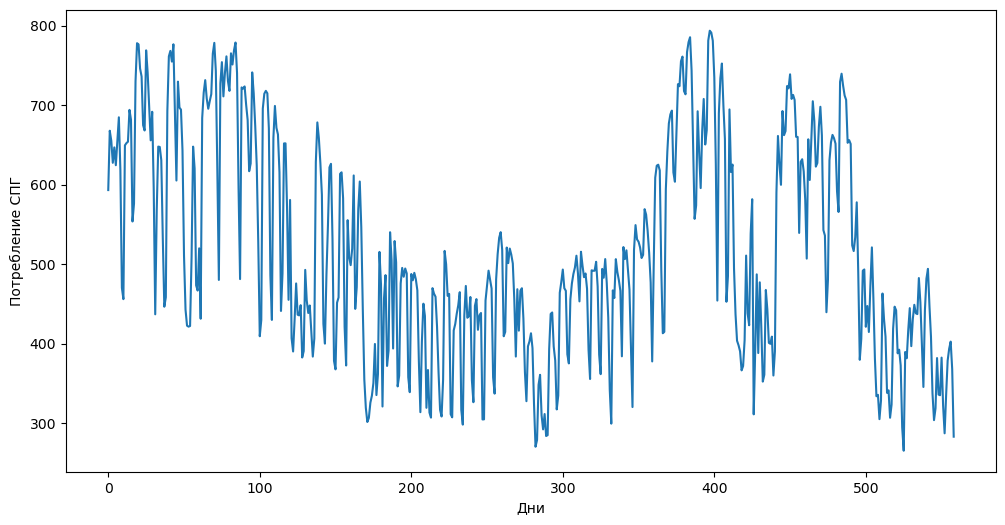

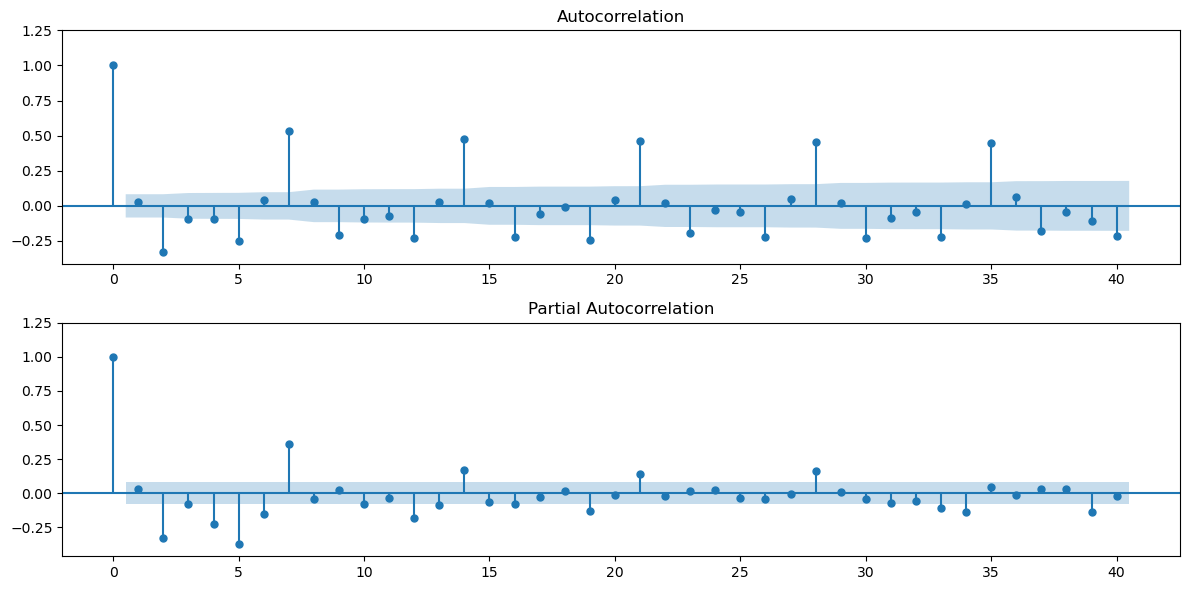

In [97]:
find_start_parameters(train.value)

In [98]:
arimax_model = SARIMAX(train_endog, exog=train_exog,
                order=(7, 1, 5))
arimax_model = arimax_model.fit()
print(arimax_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  559
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -3001.370
Date:                Mon, 24 Jul 2023   AIC                           6032.740
Time:                        14:56:43   BIC                           6097.606
Sample:                             0   HQIC                          6058.073
                                - 559                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp         -10.4548      1.144     -9.141      0.000     -12.697      -8.213
price         -1.5131      1.175     -1.288      0.198      -3.816       0.790
ar.L1         -0.4490      0.056     -8.010      0.0

In [99]:
start_predictions = arimax_model.predict(start=len(train), end=(len(train) + len(test) - 1), exog=test_exog)

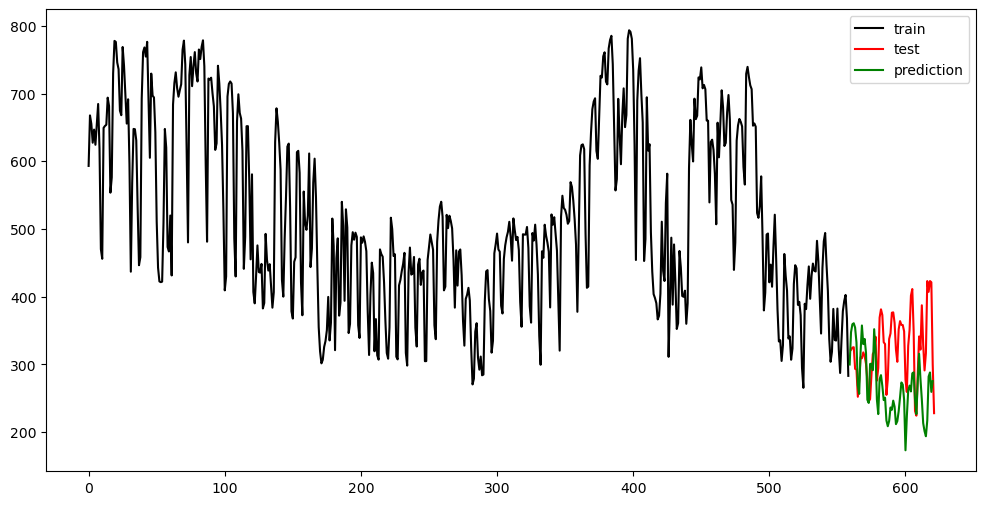

In [100]:
plt.figure(figsize=(12,6))
plt.plot(train.value, color='black', label='train')
plt.plot(test.value, color='red', label='test')
plt.plot(start_predictions, color='green', label='prediction')
plt.legend()
plt.show()

In [101]:
mean_squared_error(test.value, start_predictions)

8039.227528889679

In [102]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test.value, start_predictions)

0.21848488946349282

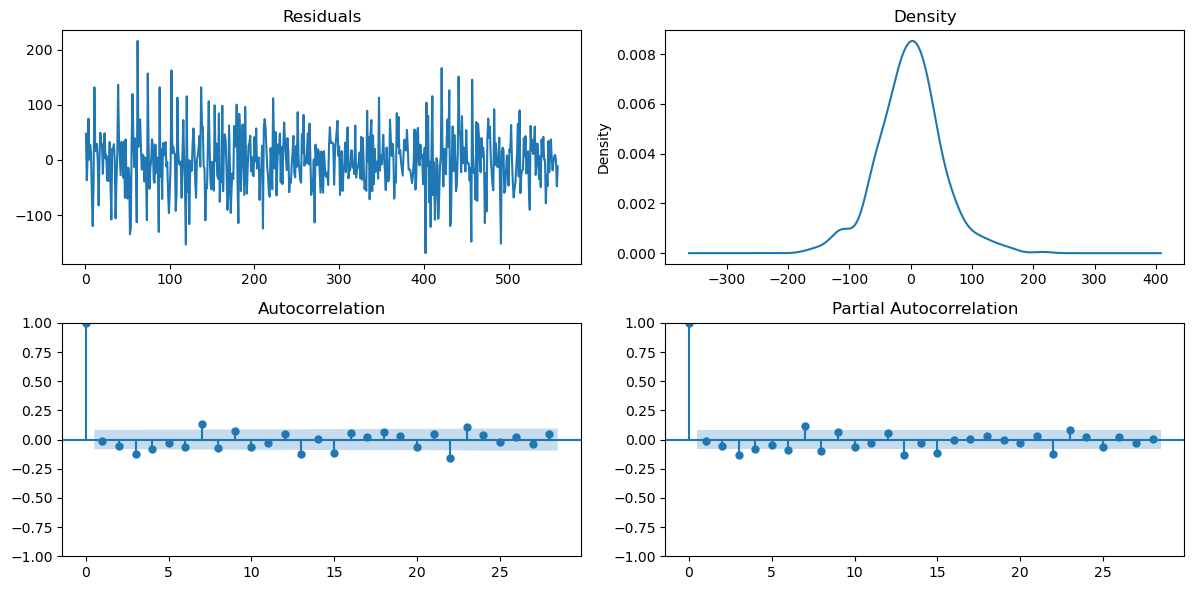

In [103]:
plot_residiuals(arimax_model)

In [104]:
df_consumption['weekday'] = df_consumption.periodFrom.apply(lambda x: x.weekday())
df_consumption

,periodFrom,value,temp,price,weekday
0,2018-11-01,593.124833,9.9,23.65,3
1,2018-11-02,667.726581,7.2,24.28,4
2,2018-11-03,655.143480,4.5,24.28,5
3,2018-11-04,627.411835,6.8,24.28,6
4,2018-11-05,646.784186,12.9,23.81,0
...,...,...,...,...,...
617,2023-07-11,407.179382,25.1,29.06,1
618,2023-07-12,423.070921,21.1,26.64,2
619,2023-07-13,421.328338,20.0,26.64,3
620,2023-07-14,300.119775,23.8,26.64,4


In [105]:
df_consumption['is_work_day'] = (df_consumption.weekday < 5).astype(int)
df_consumption.head(15)

,periodFrom,value,temp,price,weekday,is_work_day
0,2018-11-01,593.124833,9.9,23.65,3,1
1,2018-11-02,667.726581,7.2,24.28,4,1
2,2018-11-03,655.143480,4.5,24.28,5,0
3,2018-11-04,627.411835,6.8,24.28,6,0
4,2018-11-05,646.784186,12.9,23.81,0,1
5,2018-11-06,624.369402,14.0,23.90,1,1
6,2018-11-07,654.509945,10.9,24.42,2,1
7,2018-11-08,684.610994,9.3,24.43,3,1
8,2018-11-09,618.445697,9.9,24.33,4,1
9,2018-11-10,470.184233,11.7,24.33,5,0


In [106]:
df_consumption.drop(columns="weekday", inplace=True)
df_consumption.head()

,periodFrom,value,temp,price,is_work_day
0,2018-11-01,593.124833,9.9,23.65,1
1,2018-11-02,667.726581,7.2,24.28,1
2,2018-11-03,655.143480,4.5,24.28,0
3,2018-11-04,627.411835,6.8,24.28,0
4,2018-11-05,646.784186,12.9,23.81,1


In [107]:
train_1, test_1 = train_test_split(df_consumption)
train_endog_1, train_exog_1 = train_1.value, train_1[["temp", "is_work_day"]]
test_endog_1, test_exog_1 = test_1.value, test_1[["temp", "is_work_day"]]

In [108]:
train_exog_1

,temp,is_work_day
0,9.9,1
1,7.2,1
2,4.5,0
3,6.8,0
4,12.9,1
...,...,...
554,14.6,1
555,13.3,1
556,13.3,1
557,12.2,1


In [109]:
arimax_model_1 = SARIMAX(train_endog_1, exog=train_exog_1, order=(7, 1, 5))
arimax_model_1 = arimax_model_1.fit()
print(arimax_model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  559
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -2938.929
Date:                Mon, 24 Jul 2023   AIC                           5907.858
Time:                        14:57:32   BIC                           5972.724
Sample:                             0   HQIC                          5933.190
                                - 559                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp           -9.5154      1.017     -9.355      0.000     -11.509      -7.522
is_work_day    94.6867      4.768     19.859      0.000      85.342     104.032
ar.L1          -0.3372      0.059     -5.746    

In [110]:
predictions_1 = arimax_model_1.predict(start=len(train_1), end=(len(train_1) + len(test_1) - 1), exog=test_exog_1)

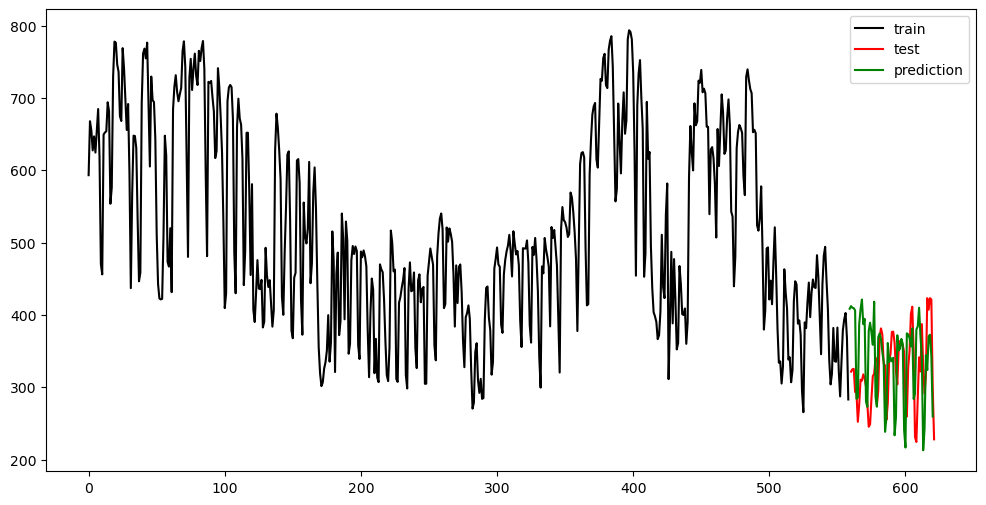

In [111]:
plt.figure(figsize=(12,6))
plt.plot(train_1.value, color='black', label='train')
plt.plot(test_1.value, color='red', label='test')
plt.plot(predictions_1, color='green', label='prediction')
plt.legend()
plt.show()

In [112]:
mean_squared_error(test_1.value, predictions_1)

3497.0372019979723

In [113]:
mean_absolute_percentage_error(test_1.value, predictions_1)

0.1550358757850041

In [114]:
predictions_1

559    408.479001
560    412.121567
561    409.805917
562    409.284805
563    406.175133
          ...    
616    323.740851
617    370.367653
618    372.557415
619    343.242931
620    259.454147
Name: predicted_mean, Length: 62, dtype: float64

In [115]:
test_1.value

560    321.501338
561    324.764013
562    325.393483
563    293.439270
564    292.250322
          ...    
617    407.179382
618    423.070921
619    421.328338
620    300.119775
621    227.941015
Name: value, Length: 62, dtype: float64

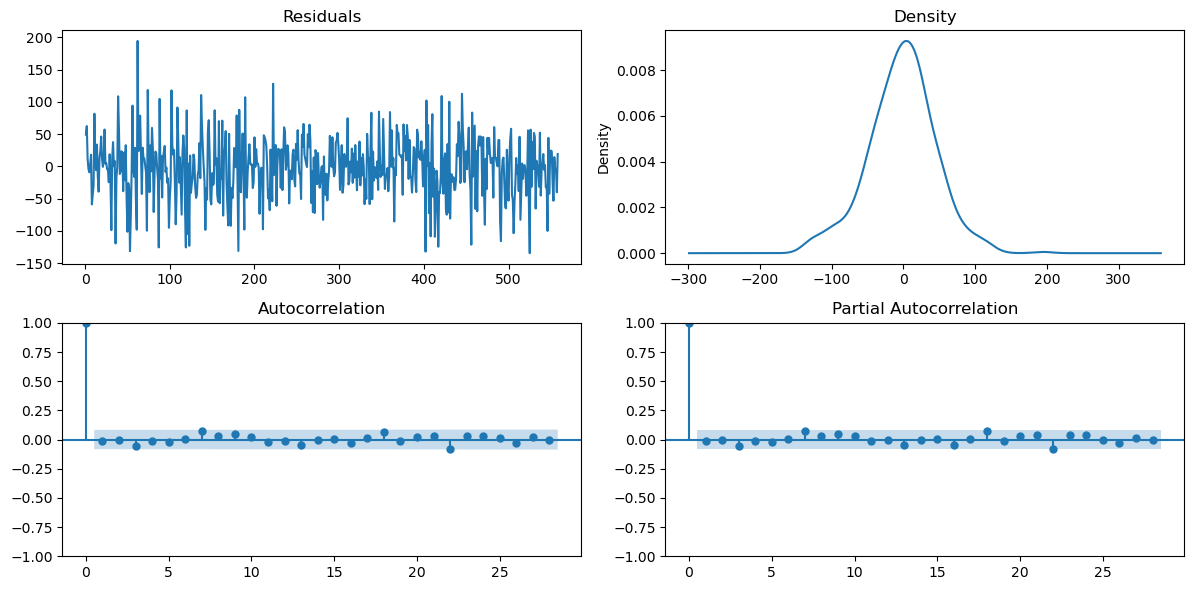

In [116]:
plot_residiuals(arimax_model_1)

In [117]:
data = df_consumption.drop(columns="periodFrom")
data.head()

,value,temp,price,is_work_day
0,593.124833,9.9,23.65,1
1,667.726581,7.2,24.28,1
2,655.143480,4.5,24.28,0
3,627.411835,6.8,24.28,0
4,646.784186,12.9,23.81,1


<Axes: >

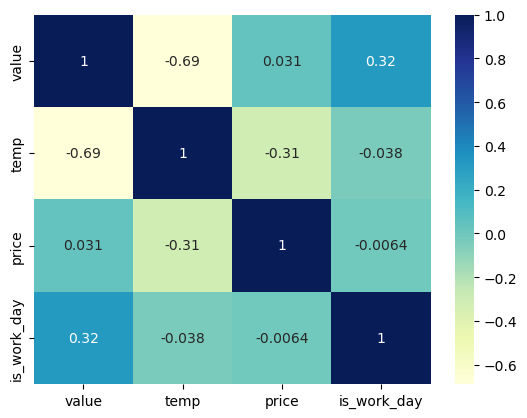

In [118]:
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

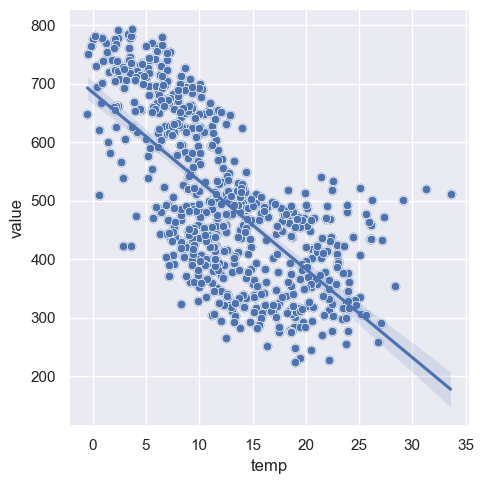

In [141]:
sns.set_style("darkgrid")
sns.lmplot(data=data, x='temp', y='value')
sns.scatterplot(data=data, x='temp', y='value')
plt.show()

In [177]:
data["active_temp"] = np.where(data.temp < 25, data.temp - 25, 0)
data

,value,temp,is_work_day,active_temp
0,593.124833,9.9,1,-15.1
1,667.726581,7.2,1,-17.8
2,655.143480,4.5,0,-20.5
3,627.411835,6.8,0,-18.2
4,646.784186,12.9,1,-12.1
...,...,...,...,...
617,407.179382,25.1,1,0.0
618,423.070921,21.1,1,-3.9
619,421.328338,20.0,1,-5.0
620,300.119775,23.8,1,-1.2


In [178]:
train_2, test_2 = train_test_split(data)
train_endog_2, test_endog_2 = train_2.value, test_2.value
train_exog_2, test_exog_2 = train_2[['active_temp', 'is_work_day']], test_2[['active_temp', 'is_work_day']]

In [179]:
arimax_model_2 = SARIMAX(train_endog_2, exog=train_exog_2, order=(7, 1, 5))
arimax_model_2 = arimax_model_2.fit()
print(arimax_model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  559
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -2935.728
Date:                Mon, 24 Jul 2023   AIC                           5901.456
Time:                        15:49:58   BIC                           5966.321
Sample:                             0   HQIC                          5926.788
                                - 559                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
active_temp   -10.9167      1.023    -10.673      0.000     -12.921      -8.912
is_work_day    94.5422      4.446     21.266      0.000      85.829     103.256
ar.L1          -0.3694      0.047     -7.790    

In [180]:
predictions_2 = arimax_model_2.predict(start=len(train_2), end=(len(train_2) + len(test_2) - 1), exog=test_exog_2)

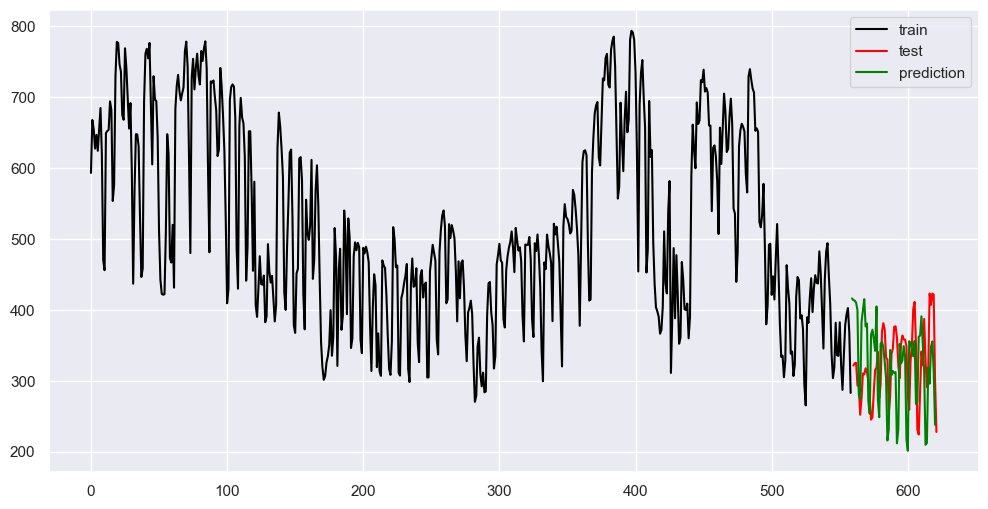

In [181]:
plt.figure(figsize=(12,6))
plt.plot(train_2.value, color='black', label='train')
plt.plot(test_2.value, color='red', label='test')
plt.plot(predictions_2, color='green', label='prediction')
plt.legend()
plt.show()

In [182]:
mean_absolute_percentage_error(test_2.value, predictions_2)

0.16040740719677893

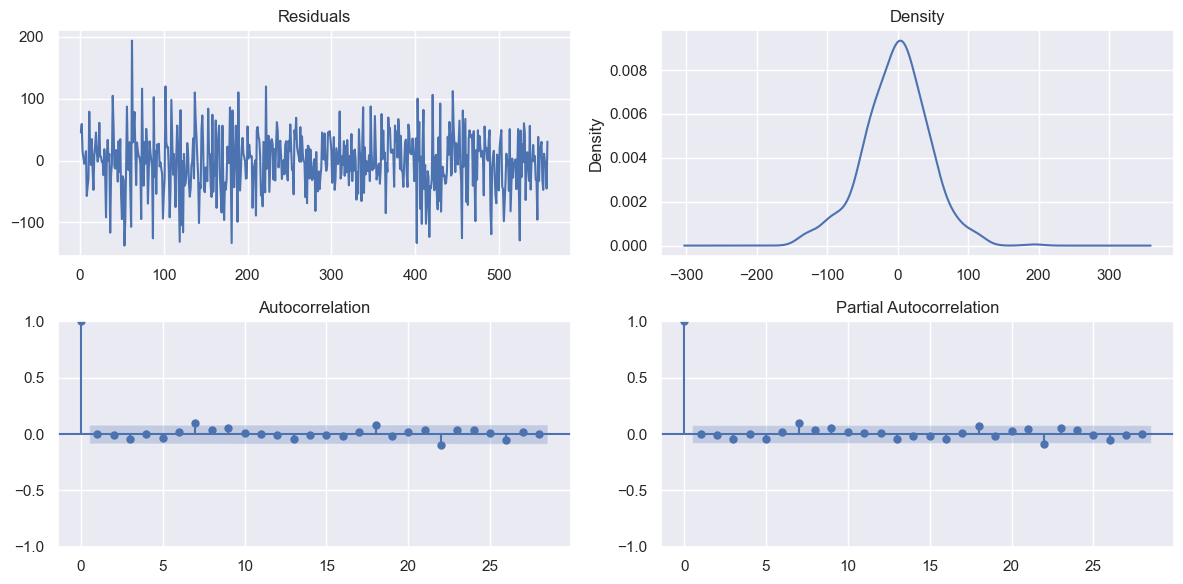

In [183]:
plot_residiuals(arimax_model_2)